## On-Policy Prediction with Linear Approximation

In this assignment I consider 3 TD-based algorithms for value prediction, namely, semi-gradient TD(0), TD with TD correction and Least-Squares TD. Experiments show that none of the algorithms converge for the specific environment considered in this task. However,they behave quite differently. 

- Standard semi-gradient TD diverges from the start.
- TD with error correction (from fast gradient TD paper) starts to converge, but eventually diverges later during training
- Least Squares TD behaves more erratically. It also initially converges (more slowly than TDC), however shows more fluctuation

Random policies were considered for all the algorithms in this notebook.

In order to insure that there was no problem with the RBF features used, I also evaluated 2 contol algorithms (presented in another notebook). Both those agorithms were able to solve the task,i.e. get the car up the mountain, hence confirming that the feature processing was done correctly.

In [47]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import sys
import sklearn.pipeline
import sklearn.preprocessing
import matplotlib.pyplot as plt
if "../" not in sys.path:
  sys.path.append("../") 
from lib import plotting
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler

matplotlib.style.use('ggplot')

The mountain car enviroment is represents a good candidate for value function approximation. This is because the state space is continuous. The state of the mountain car is given by its 2-dimensional co-ordinates. The lowest point is [-1.2 , -0.07], which the co-ordinates of top of the mountain are [0.6 ,0.07]. The goal of course, is to get the car to the top of the mountain.

[2017-03-30 22:55:46,952] Making new env: MountainCar-v0


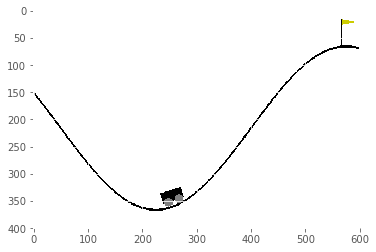

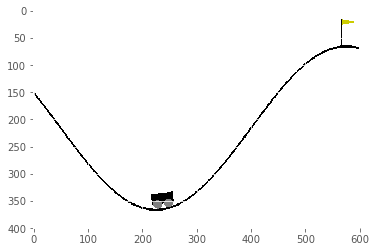

In [48]:
env = gym.envs.make("MountainCar-v0")

env.reset()
plt.figure()
plt.imshow(env.render(mode='rgb_array'))

[env.step(0) for x in range(10000)]
plt.figure()
plt.imshow(env.render(mode='rgb_array'))

env.render(close=True)

There are several ways in which the states can be converted to features. I used Radial Basis Fuctions to featurize the states. 10000 random state samples are taken from the enviroment for training the RBF sampler.

In [49]:
#collect some s-a-s triplets for calculating RMSBE
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
sample_states=[]
for st in observation_examples:
    action = np.random.randint(0,2)
    next_state, reward, done, _ = env.step(action)
    sample_states.append((st,next_state,reward))
    

In [50]:
# Feature Preprocessing: Normalize to zero mean and unit variance
# We use a few samples from the observation space to do this
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])

scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

# Used to converte a state to a featurizes represenation.
# We use RBF kernels with different variances to cover different parts of the space
featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
featurizer.fit(scaler.transform(observation_examples))

FeatureUnion(n_jobs=1,
       transformer_list=[('rbf1', RBFSampler(gamma=5.0, n_components=100, random_state=None)), ('rbf2', RBFSampler(gamma=2.0, n_components=100, random_state=None)), ('rbf3', RBFSampler(gamma=1.0, n_components=100, random_state=None)), ('rbf4', RBFSampler(gamma=0.5, n_components=100, random_state=None))],
       transformer_weights=None)

In [51]:
def featurize_state(state):
        """
        Returns the featurized representation for a state.
        """
        scaled = scaler.transform([state])
        featurized = featurizer.transform(scaled)
        return featurized[0]

### semi-gradient TD

In [91]:
def sgTD(env, Theta, num_episodes, discount_factor=1.0, epsilon=0.1, epsilon_decay=1.0):
  

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    count=0
    rmsbe_states=[]
    cc=0
    rms=[]
    for i_episode in range(num_episodes):
        
        # The policy we're following
        policy = make_epsilon_greedy_policy(
            Theta, epsilon * epsilon_decay**i_episode, env.action_space.n)
        
        # Print out which episode we're on, useful for debugging.
        # Also print reward for last episode
        last_reward = stats.episode_rewards[i_episode - 1]
        sys.stdout.flush()
        
        # Reset the environment and pick the first action
        state = env.reset()
        
        # Only used for SARSA, not Q-Learning
        next_action = None
        
        # One step in the environment
        for t in itertools.count():
            BErms=0
            #featurize present state and predict its value
            phi_s = featurize_state(state)
            q_values_s = np.dot(Theta.T,phi_s)
            # Choose an action to take
            # If we're using SARSA we already decided in the previous step
            
            #if next_action is None:
                #action_probs = policy(state)
                #action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            #else:
                #action = next_action
            
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            
            #action = np.random.randint(0,2)
            
            # Take a step
            next_state, reward, done, _ = env.step(action)
            
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # TD Update
            #q_values_next = estimator.predict(next_state)

            #featurize next state and predict its value
            phi_ns = featurize_state(next_state)
            q_values_next = np.dot(Theta.T,phi_ns)

            #estimator.update(state, action, td_target)
            Theta += 0.0003*(reward + q_values_next - q_values_s)*phi_s
            #Theta[:,action] += 0.1*(reward + np.max(q_values_next) - q_values_s[action])*phi_s
            cc+=1
            state=next_state
            
            #evaluate after update to theta
            if cc==25:
                break
            #print(len(rmsbe_states))
            for st,nst,rwd in sample_states:
               
                phis = featurize_state(st)

                phins = featurize_state(nst)
    
                V_values_l = np.dot(Theta.T,phis)
                V_target = rwd+np.dot(Theta.T,phins)        
                BErms += (V_target - V_values_l)**2
            
            print('RMSBE: {}'.format(np.sqrt(BErms))) 
            rms.append(np.sqrt(BErms))   
            
            #print("\rStep {} @ Episode {}/{} ({})".format(t, i_episode + 1, num_episodes, last_reward),end="")

            if done:
                break
                
            state = next_state
    
    return stats,rms

In [92]:
# Note: For the Mountain Car we don't actually need an epsilon > 0.0
# because our initial estimate for all states is too "optimistic" which leads
# to the exploration of all states.
Theta = np.zeros((400,))
SGstats,TDrms = sgTD(env, Theta, 1, epsilon=0.0)

RMSBE: 100.03721355054229
RMSBE: 100.07449442554382
RMSBE: 100.11185732871931
RMSBE: 100.14931603780144
RMSBE: 100.18688308373102
RMSBE: 100.22456946665956
RMSBE: 100.2623844249736
RMSBE: 100.30033526969244
RMSBE: 100.33842729116111
RMSBE: 100.37666373863395
RMSBE: 100.41504586697546
RMSBE: 100.45357303919657
RMSBE: 100.49224286973735
RMSBE: 100.53105139175263
RMSBE: 100.56999323240593
RMSBE: 100.60906178305319
RMSBE: 100.64824935569636
RMSBE: 100.68754732231913
RMSBE: 100.7269462388065
RMSBE: 100.76643595917496
RMSBE: 100.80600574817696
RMSBE: 100.84564440071553
RMSBE: 100.88534037497863
RMSBE: 100.92508194326594


### semi-gradient TD with TDC

In [94]:
def TDC(env, Theta, num_episodes, discount_factor=1.0, epsilon=0.1, epsilon_decay=1.0):
    """
    Q-Learning algorithm for fff-policy TD control using Function Approximation.
    Finds the optimal greedy policy while following an epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        estimator: Action-Value function estimator
        num_episodes: Number of episodes to run for.
        discount_factor: Lambda time discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
        epsilon_decay: Each episode, epsilon is decayed by this factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    w_s = np.zeros((400,))
    cc=0
    rms=[]
    for i_episode in range(num_episodes):
        
        # The policy we're following
        policy = make_epsilon_greedy_policy(
            Theta, epsilon * epsilon_decay**i_episode, env.action_space.n)
        
        # Print out which episode we're on, useful for debugging.
        # Also print reward for last episode
        last_reward = stats.episode_rewards[i_episode - 1]
        sys.stdout.flush()
        
        # Reset the environment and pick the first action
        state = env.reset()
        
        # Only used for SARSA, not Q-Learning
        next_action = None
        
        # One step in the environment
        for t in itertools.count():
            BErms=0
            #featurize present state and predict its value
            phi_s = featurize_state(state)
            q_values_s = np.dot(Theta.T,phi_s)
            
            # Choose an action to take
            # If we're using SARSA we already decided in the previous step
            if next_action is None:
                #action_probs = policy(state)
                #action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
                action = np.random.randint(0,2)
            else:
                action = next_action
            
            #action_probs = policy(state)
            #action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            
            # Take a step
            next_state, reward, done, _ = env.step(action)
    
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # TD Update
            #q_values_next = estimator.predict(next_state)

            #featurize next state and predict its value
            phi_ns = featurize_state(next_state)
            q_values_next = np.dot(Theta.T,phi_ns)
            
            td_error = reward + q_values_next - q_values_s
            
            Theta += 0.001*td_error*phi_s - 0.1*np.dot(phi_s.T,w_s)*phi_ns
            w_s += 0.001*(td_error - np.dot(phi_s.T,w_s))*phi_s
            
            state=next_state
            
            if cc==25:
                break
            cc+=1
            
            for st,nst,rwd in sample_states:
                phis = featurize_state(st)

                phins = featurize_state(nst)
    
                V_values_l = np.dot(Theta.T,phis)
                V_target = rwd+np.dot(Theta.T,phins)        
                BErms += (V_target - V_values_l)**2
            
            print('RMSBE: {}'.format(np.sqrt(BErms)))
            rms.append(np.sqrt(BErms))
            
            #print("\rStep {} @ Episode {}/{} ({})".format(t, i_episode + 1, num_episodes, last_reward),end="")
                
            if done:
                break
                
            state = next_state
    
    return stats,rms

In [95]:
# Note: For the Mountain Car we don't actually need an epsilon > 0.0
# because our initial estimate for all states is too "optimistic" which leads
# to the exploration of all states.
Theta1 = np.zeros((400,))
TDCstats,TDCrms = TDC(env, Theta1, 100, epsilon=0.0)

RMSBE: 100.1185044071684
RMSBE: 100.19237991686738
RMSBE: 100.22143246916875
RMSBE: 100.2056507953239
RMSBE: 100.14501935965971
RMSBE: 100.03979782704286
RMSBE: 99.88841971108435
RMSBE: 99.69223378210833
RMSBE: 99.45167606940102
RMSBE: 99.16707952523458
RMSBE: 98.8352149748361
RMSBE: 98.45641671428527
RMSBE: 98.03152533133364
RMSBE: 97.56367394812703
RMSBE: 97.05097866877367
RMSBE: 96.4980701411162
RMSBE: 95.90540867930224
RMSBE: 95.27102419428272
RMSBE: 94.59912070489128
RMSBE: 93.8886286496779
RMSBE: 93.14545821637543
RMSBE: 92.37195533135052
RMSBE: 91.57048530441752
RMSBE: 90.74341969324152
RMSBE: 89.88867716246885


## Least Squares TD

In [98]:
def sgTD(env, A,b,Theta, num_episodes, discount_factor=1.0, epsilon=0.1, epsilon_decay=1.0):


    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    count=0
   
    cc=0
    rms=[]
    for i_episode in range(num_episodes):
        
        # The policy we're following
        policy = make_epsilon_greedy_policy(
            Theta, epsilon * epsilon_decay**i_episode, env.action_space.n)
        
        # Print out which episode we're on, useful for debugging.
        # Also print reward for last episode
        last_reward = stats.episode_rewards[i_episode - 1]
        sys.stdout.flush()
        
        # Reset the environment and pick the first action
        #initialize state and corresponding phi
        state = env.reset()
        
        phi_store = np.empty((400,))
        # Only used for SARSA, not Q-Learning
        #next_action = None
    
        # One step in the environment
        for t in itertools.count():
            #featurize present state and predict its value
            BErms=0
            phi_s = featurize_state(state)
            V_values_p = np.dot(Theta.T,phi_s)
            
            #action_probs = policy(state)
            #action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            action = np.random.randint(0,2)
            
            # Take a step
            next_state, reward, done, _ = env.step(action)

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # TD Update
            #q_values_next = estimator.predict(next_state)

            #featurize next state and predict its value
            phi_ns = featurize_state(next_state)
            
            phi_store+=phi_s
            d = phi_s.flatten() - phi_ns.flatten()
            A= A + np.outer(d,phi_store)
            
            b =phi_store*reward
            
            B = np.linalg.pinv(A)
            #estimator.update(state, action, td_target)
            kk=np.dot(B,b[:,None])
            #Estimate new theta
            Theta = kk.flatten()
            
            if cc==25:
                break
            cc+=1
            
            for st,nst,rwd in sample_states:
                phis = featurize_state(st)

                phins = featurize_state(nst)
    
                V_values_l = np.dot(Theta.T,phis)
                V_target = rwd+np.dot(Theta.T,phins)        
                BErms += (V_target - V_values_l)**2
            
            
            print('RMSBE: {}'.format(np.sqrt(BErms)))
            rms.append(np.sqrt(BErms))
            #V_target = reward+np.dot(Theta.T,phi_ns)        
            #print(V_target)
            

            if done:
                break
                
            state = next_state
                            
    return stats,rms

In [99]:
# Note: For the Mountain Car we don't actually need an epsilon > 0.0
# because our initial estimate for all states is too "optimistic" which leads
# to the exploration of all states.
epsilon = np.eye(400)*np.random.normal(size=(400,))
A = np.zeros((400,400))+epsilon
b = np.zeros((400,))
LDTheta = np.zeros((400,))

LDstats,LDrms = sgTD(env,A,b,LDTheta,1, epsilon=0.0)

RMSBE: 100.08303938796101
RMSBE: 100.01029754224906
RMSBE: 100.00641339955686
RMSBE: 100.00514831604242
RMSBE: 100.0046129006549
RMSBE: 100.00439639215725
RMSBE: 100.00435679761974
RMSBE: 100.00489942858476
RMSBE: 100.00491058946662
RMSBE: 100.00501527040059
RMSBE: 100.00518372629885
RMSBE: 100.00573683672621
RMSBE: 100.00589883549696
RMSBE: 100.00642749272521
RMSBE: 100.0069215674021
RMSBE: 100.00701397456264
RMSBE: 100.00743855960978
RMSBE: 100.00779334435803
RMSBE: 100.00782170018951
RMSBE: 100.00785896258886
RMSBE: 100.00790089741857
RMSBE: 100.00794452818968
RMSBE: 100.00811939273947
RMSBE: 100.00819536144472
RMSBE: 100.00818657834799


## Figure

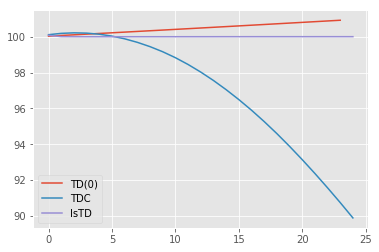

In [103]:
TDrms = np.asarray(TDrms,dtype='float32')
TDCrms = np.asarray(TDCrms,dtype='float32')
LDrms = np.asarray(LDrms,dtype='float32')
plt.plot(TDrms)
plt.plot(TDCrms)
plt.plot(LDrms)
plt.legend(['TD(0)', 'TDC', 'lsTD'], loc='lower left')
plt.show()